In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
sys.path.insert(1, r'C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\tree_models\tree_model_functions.py')
import tree_model_functions

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Selecting the DataSource
dataSource = r"C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\students_data\cleaned_data_with_IQR_removal.csv"

# Selecting columns to drop out of featureList and creating LabelList
featureDropList = ["_id", "observationDate", "state", "city", "AP_community","postcode", "base_rent", "qm2_rent", "DE_qm2_rent"]
LabelList = ["qm2_rent"]

# Create DataFrame from DataSource
df = pd.read_csv(dataSource)



In [4]:
df["state"].value_counts()

Sachsen                   18888
Nordrhein-Westfalen       16243
Bayern                    14260
Baden-Württemberg          8165
Niedersachsen              7401
Sachsen-Anhalt             7102
Hessen                     6310
Thüringen                  4539
Hamburg                    3260
Schleswig-Holstein         3153
Rheinland-Pfalz            2775
Mecklenburg-Vorpommern     2718
Berlin                     2290
Brandenburg                2177
Bremen                     1068
Saarland                   1021
Name: state, dtype: int64

In [5]:
# Create feature and label lists
y = df[LabelList]
X = df.drop(featureDropList, axis = 1)
feature_list = list(X.columns)

y = np.array(y)
X = np.array(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Instantiate model
rf = RandomForestRegressor()


# Train the model on training data
rf.fit(X_train, y_train)

# Use the Regressors's predict method on the test data
predictions = rf.predict(X_test)

assert len(predictions) == len(y_test), 'Length of predictions is not len y_test'
# Calculate relative prediction errors
errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range((len(predictions)))]

# Count of predictions that are at least 10% accurate
count_good_predictions = sum(1 for i in errors if i <= 10)

# Proportion of good predictions for the Testset
good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)

good_predictions

C:\Users\soube\AppData\Local\Temp\ipykernel_11416\2624532215.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


67.42

In [6]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (81096, 150)
Training Labels Shape: (81096, 1)
Testing Features Shape: (20274, 150)
Testing Labels Shape: (20274, 1)


In [7]:
# feature importance
importances = list(rf.feature_importances_)
feature_importances = sorted([(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)], key=lambda x: x[1], reverse = True)

In [8]:
sum(row[1] for row in feature_importances)

1.0039999999999998

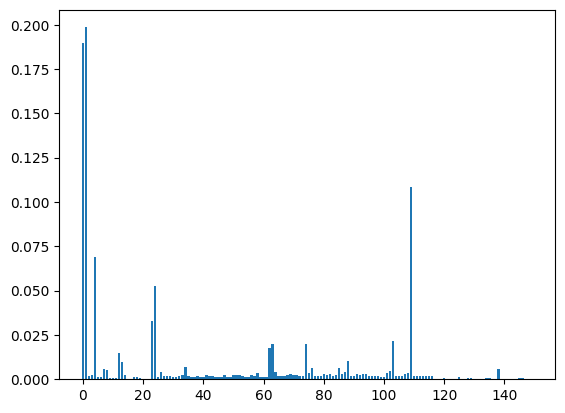

In [9]:
# plot
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.show()

Text(0.5, 1.0, 'Cumulative Importances')

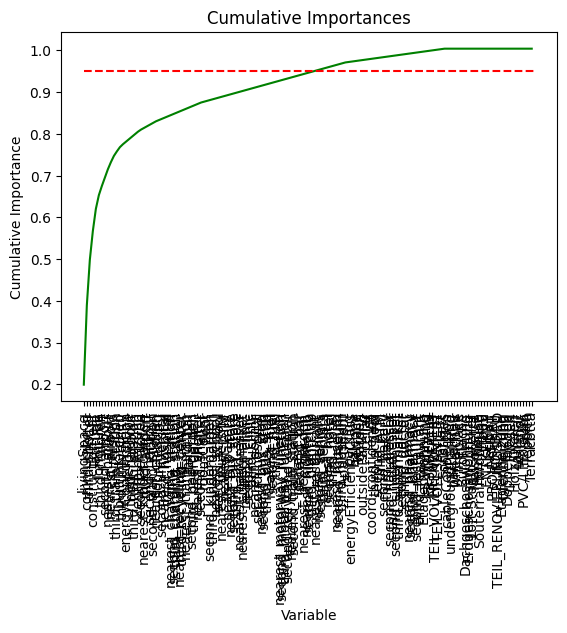

In [10]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
x_values = list(range(len(feature_importances)))

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

In [11]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 90% importance: 78


In [12]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:np.where(cumulative_importances > 0.95)[0][0] + 1]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_X_train = X_train[:, important_indices]
important_X_test = X_test[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_X_train.shape)
print('Important test features shape:', important_X_test.shape)

Important train features shape: (81096, 78)
Important test features shape: (20274, 78)


In [13]:
# Train the expanded model on only the important features
rf.fit(important_X_train, y_train)

C:\Users\soube\AppData\Local\Temp\ipykernel_23636\1702952482.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(important_X_train, y_train)


RandomForestRegressor()

In [14]:
# Make predictions on test data
predictions = rf.predict(important_X_test)

In [30]:
# Calculate relative prediction errors
errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

# Count of predictions that are at least 10% accurate
count_good_predictions = sum(1 for i in errors if i <= 10)

# Proportion of good predictions for the Testset
good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

Percentage of predictions with less than 10 % deviation:  66.57 %.


In [13]:
# Create dataframe with community_ids and associated predictions and y_test
evaluation_df = pd.DataFrame()
evaluation_df["raw_qm_rent_prediction"] = predictions
evaluation_df["real_qm_rent"] = y_test
evaluation_df["community_id"] = df["community_id"]
evaluation_df["postcode"] = df["postcode"]
evaluation_df.head()

,raw_qm_rent_prediction,real_qm_rent,community_id,postcode
0,9.136599,9.988249,1062,22885
1,23.181818,23.181818,1003,23556
2,5.276686,5.216904,1056,25421
3,6.369235,6.242038,1061,25554
4,9.192175,7.200000,1004,24539


### Evaluate with postcode ###

In [9]:
df_Abschlagliste_postcodes = pd.read_csv(r"C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\students_data\Abschlagliste_AP_communitys_with_IQR_removal.csv")
# Merge evaluation dataset with Factors
evaluation_df = pd.merge(evaluation_df, df_Abschlagliste_postcodes[["postcode","averageQmRent_postcode","Abschlag_Faktor_postcode","Absoluter_Abschlag_postcode"]], on=['postcode'], how='left') 

In [14]:
evaluation_df.head()

,raw_qm_rent_prediction,real_qm_rent,community_id,postcode,averageQmRent_postcode,Abschlag_Faktor_postcode,Absoluter_Abschlag_postcode,raw_error %,qm_rent_prediction,error %
0,9.088009,9.988249,1062,22885,11.529344,1.209760,1.999072,9.012994e+00,10.994312,10.072465
1,23.181818,23.181818,1003,23556,9.445206,0.991074,-0.085065,1.532543e-14,22.974902,0.892581
2,5.348169,5.216904,1056,25421,11.744405,1.232326,2.214133,2.516147e+00,6.590689,26.333346
3,6.378190,6.242038,1061,25554,7.383141,0.774704,-2.147131,2.181212e+00,4.941210,20.839795
4,8.785490,7.200000,1004,24539,8.026680,0.842230,-1.503592,2.202070e+01,7.399403,2.769485


In [11]:
errors = 100 * (abs(evaluation_df["raw_qm_rent_prediction"] - evaluation_df["real_qm_rent"])) / evaluation_df["real_qm_rent"]
evaluation_df["raw_error %"] = errors

# Count of predictions that are at least 10% accurate
count_good_predictions = sum(1 for i in errors if i <= 10)

# Proportion of good predictions for the Testset
good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)

good_predictions

67.33

In [12]:
# Calculate predictions with community-specific factors
evaluation_df["qm_rent_prediction"] = evaluation_df["raw_qm_rent_prediction"] * evaluation_df["Abschlag_Faktor_postcode"]

In [13]:
errors = 100 * (abs(evaluation_df["qm_rent_prediction"] - evaluation_df["real_qm_rent"])) / evaluation_df["real_qm_rent"]
evaluation_df["error %"] = errors

# Count of predictions that are at least 10% accurate
count_good_predictions = sum(1 for i in errors if i <= 10)

# Proportion of good predictions for the Testset
good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)

good_predictions

17.88

### Random Search ###

In [17]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]
    count_good_predictions = sum(1 for i in errors if i <= 10)
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

In [18]:
subset_important_X_train = important_X_train[1::10]
subset_y_train = y_train[1::10]

In [19]:
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion: just squared error beacuse it's much faster than the other options
# Maximum number of levels in tree
max_depth = [None]
# Number of features to consider at every split
max_features = [1.0, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Number of trees in random forest
n_estimators = n_estimators = [int(x) for x in np.linspace(start= 10, stop = 100, num = 10)]
# Random state
random_state = [0]

# Create the random grid
random_grid = { 'bootstrap': bootstrap,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'n_estimators': n_estimators,
               'random_state': random_state
               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                    n_iter = 10, scoring = 'neg_mean_absolute_error', 
                    cv = 3, verbose = 3, random_state = 0, n_jobs=-1)

# Fit the random search model
random_search.fit(important_X_train, y_train)

print("Best Params: ", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits



### n_iter = 10
### Best Params:  {'random_state': 0, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 50, 'max_depth': None, 'bootstrap': False}

### Random searched model performence: 68.07 %.
### Base model Performance: 65.59 %. ### 

In [ ]:
# With only important features and this Hyperparameter combination we get this performance
#RandomForestRegressor(bootstrap=False, max_depth=None, max_features=50, n_estimators=90, random_state = 0, min_samples_leaf= 1,min_samples_split= 2)
# Performance = 70.27%

In [ ]:
# Evaluating grid searched model after Hyperparameter Tuning
best_grid = random_search.best_estimator_
evaluate_model(best_grid, important_X_test, y_test)

Percentage of predictions with less than 10 % deviation:  68.07 %.


In [ ]:
# Evaluating base model without Hyperparameter Tuning
base_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
base_model.fit(important_X_train, y_train)
evaluate_model(base_model, important_X_test, y_test)

C:\Users\soube\AppData\Local\Temp\ipykernel_8120\1726716671.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(important_X_train, y_train)


KeyboardInterrupt: 

### Grid Search ###